                                                          LiDAR Point Cloud Vectorization

LiDAR Point Cloud Vectorization converts raw LiDAR data into structured vector information.

It involves processing 3D point cloud data captured by LiDAR sensors.

The process includes noise removal, classification, and feature extraction.

Algorithms segment and identify objects like buildings, vegetation, and roads.

Vectorization transforms point clouds into polygons, lines, and points.


In [1]:
# Base Libraries
import numpy as np  # Importing NumPy for numerical operations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
import pandas as pd  # Importing Pandas for data manipulation
import tkinter as tk  # Importing Tkinter for GUI components
from tkinter import filedialog  # Importing filedialog submodule from Tkinter

# 3D Libraries
import open3d as o3d  # Importing Open3D for 3D visualization and processing
import laspy  # Importing laspy for reading and writing LAS file format
print(laspy.__version__)  # Printing laspy version

# Geospatial Libraries
import rasterio  # Importing rasterio for reading and writing raster data
import alphashape as ash  # Importing alphashape for creating alpha shapes
import geopandas as gpd  # Importing geopandas for geospatial data manipulation
import shapely as sh  # Importing shapely for geometric operations

from rasterio.transform import from_origin  # Importing from_origin from rasterio.transform
from rasterio.enums import Resampling  # Importing Resampling enumeration from rasterio.enums
from rasterio.features import shapes   # Importing shapes function from rasterio.features
from shapely.geometry import Polygon    # Importing Polygon class from shapely.geometry



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3


In [2]:
las = laspy.read('points.laz')

# Exploring the classification areas
print(np.unique(las.classification))

# Print dimensions' names
print([dimension.name for dimension in las.point_format.dimensions])

# Check available attributes for the VLR object
vlr_attributes = dir(las.vlrs[2])

# Print available attributes for the VLR object
print("VLR Attributes:", vlr_attributes)

# Use the correct attribute based on your requirements
# For example, if you want to get the raw data as a string, you might use:
if 'raw_data' in vlr_attributes:
    crs = las.vlrs[2].raw_data
    print("CRS Raw Data:", crs)
else:
    print("VLR object does not have 'raw_data' attribute.")

[1 2]
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']
VLR Attributes: ['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_description', '_record_id', '_user_id', 'description', 'record_data', 'record_data_bytes', 'record_id', 'user_id']
VLR object does not have 'raw_data' attribute.


In [3]:
# Data preprocessing 

#mask to filter points
pts_mask = las.classification == 1


#coordinates
xyz_t = np.vstack((las.x[pts_mask],las.y[pts_mask],las.z[pts_mask]))

#transformation and visualization
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points =o3d.utility.Vector3dVector(xyz_t.transpose())

#translation of point cloud 
pcd_center = pcd_o3d.get_center()
pcd_o3d.translate(pcd_center)

#visualization of result
o3d.visualization.draw_geometries([pcd_o3d])



[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [4]:
# Data preprocessing  for ground points

#mask to filter points
pts_mask = las.classification == 2


#coordinates
xyz_t = np.vstack((las.x[pts_mask],las.y[pts_mask],las.z[pts_mask]))

#transformation and visualization
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points =o3d.utility.Vector3dVector(xyz_t.transpose())

#translation of point cloud 
pcd_center = pcd_o3d.get_center()
pcd_o3d.translate(pcd_center)

#visualization of result
o3d.visualization.draw_geometries([pcd_o3d])



In [5]:
# Mask to filter building points (classification 1)
building_mask = las.classification == 1

# Mask to filter ground points (classification 2)
ground_mask = las.classification == 2

# Coordinates of building points
xyz_building = np.vstack((las.x[building_mask], las.y[building_mask], las.z[building_mask]))

# Coordinates of ground points
xyz_ground = np.vstack((las.x[ground_mask], las.y[ground_mask], las.z[ground_mask]))

# Downsample the data
building_downsampled = xyz_building[:, ::10]  # Adjust the step size as needed
ground_downsampled = xyz_ground[:, ::10]

# Calculate distances for the downsampled data
distances = np.linalg.norm(building_downsampled[:, np.newaxis, :] - ground_downsampled[:, :, np.newaxis], axis=0)

# Filter out invalid distances (e.g., distances between the same points)
valid_distances = distances[~np.isnan(distances)]

# Calculate the average distance
avg_distance = np.mean(valid_distances)

print(f"Average distance between ground and building points: {avg_distance} units")

Average distance between ground and building points: 71.58848959670135 units


In [6]:
# Unsupervised clustering using DBSCAN

epsilon = 2  # Set the epsilon parameter for DBSCAN
min_cluster_points = 100  # Set the minimum number of points in a cluster

# Perform DBSCAN clustering on the point cloud
labels = np.array(pcd_o3d.cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
max_label = labels.max()  # Get the maximum label assigned by DBSCAN
print(f"Point cloud has {max_label+1} clusters")

# Color pattern to generate visualization
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))  # Generate colors based on cluster labels
colors[labels < 0] = 0  # Set colors for noise points to black
pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])  # Set colors to the point cloud

# Point Cloud Visualization
o3d.visualization.draw_geometries([pcd_o3d])  # Visualize the clustered point cloud


Point cloud has 9 clusters


In [7]:
#selection of a particular segment
sel = 1
segment = pcd_o3d.select_by_index(np.where(labels == sel)[0])
o3d.visualization.draw_geometries([segment])

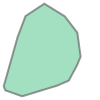

In [8]:
# Extracting the outline of the above selection

points_2D = np.asarray(segment.points)[:, 0:2]  # Extracting only x and y coordinates from the segment points

# Alpha shape 

# Generate an alpha shape from the 2D points with a specified alpha value
building_vector = ash.alphashape(points_2D, alpha=0.5)

In [9]:
#storing in geodataframe
building_gdf = gpd.GeoDataFrame(geometry=[building_vector],crs='EPSG:26910')
building_gdf.head(1)

,geometry
0,"POLYGON ((1392758.914 7822459.647, 1392758.204..."


The local minima along z axis 17.13783525368464
The local maxima along z axis 17.41783525368464


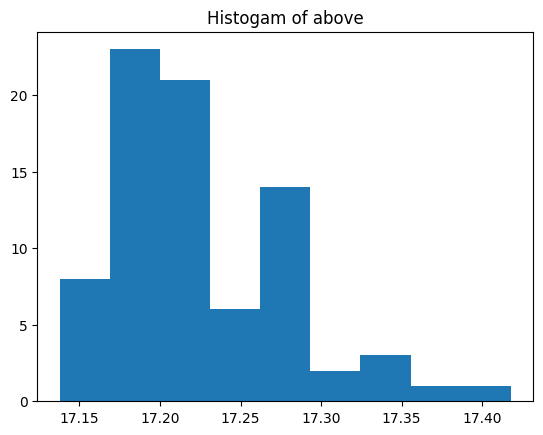

In [10]:

points_1D = np.asarray(segment.points)[:, 2]  # Extracting only the z coordinates from the segment points

# Print the local minima and maxima along the z-axis
print("The local minima along the z-axis:", np.min(points_1D))
print("The local maxima along the z-axis:", np.max(points_1D))

# Create a histogram of the z-axis coordinates
plt.hist(points_1D, bins='auto')  # 'auto' option automatically determines the number of bins
plt.title("Histogram of above")  # Set the title of the histogram
plt.show()  # Display the histogram


In [11]:
# 2D to 3D Library

# base layer
vertices = list(building_vector.exterior.coords)

# construct in open3d
Polygon_2d = o3d.geometry.LineSet()
Polygon_2d.points = o3d.utility.Vector3dVector([point + (0,) for point in vertices])
Polygon_2d.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])

# show
o3d.visualization.draw_geometries([Polygon_2d])


In [12]:
#genrate some element for the extruded

extrusion = o3d.geometry.LineSet()

Polygon_2d = o3d.geometry.LineSet()
extrusion.points = o3d.utility.Vector3dVector([point + (0,) for point in vertices])
extrusion.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])
o3d.visualization.draw_geometries([Polygon_2d,extrusion])

#plot the vertices

temp = Polygon_2d + extrusion
temp.points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = temp.points
o3d.visualization.draw_geometries([temp_o3d])


[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [13]:
import open3d as o3d
import numpy as np

# Create a simple mesh (replace this with your actual mesh creation logic)
vertices = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0]])
triangles = np.array([[0, 1, 2]])
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(vertices)
mesh.triangles = o3d.utility.Vector3iVector(triangles)

# Translation vector
pcd_center = [1, 2, 3]

# Translate the mesh
mesh.translate(pcd_center)

# Now, you can proceed with writing the mesh to a file using write_triangle_mesh
output_mesh_path = r'D:\Resume Project\Lidar_cloud_data\house_sample.ply'
o3d.io.write_triangle_mesh(output_mesh_path, mesh, write_ascii=False, compressed=True, print_progress=False)


True